In [1]:
import ase
import matplotlib.pyplot as plt
import numpy as np

import abtem

abtem.config.set({"local_diagnostics.progress_bar": True});

# Partial coherence

### Plane Waves

In [3]:
#for plane waves -> partial temporal coherence (due to energy spread) much more important than partial spacial coherence (due to source size)

#setup test system
atoms = ase.build.mx2(vacuum=2)
plane_wave = abtem.PlaneWave(energy=80e3, sampling=0.05)
exit_wave = plane_wave.multislice(atoms)

In [4]:
#A small spread in energy of the incident electrons is due to the chromatic aberration of the objective lens equivalent to a small spread in defocus
#first: coherent and quasi-coherent simulations, we use Scherzer defocus with a spherical aberration of 20 micrometers and a focal spread of 52.5 Å (vgl walkthrough ctf)
energy = 80e3
Cs = -20e-6 * 1e10
focal_spread = 52.50

#COHERENT
# Simulate coherent image
ctf_coherent = abtem.CTF(Cs=Cs, energy=energy)
ctf_coherent.defocus = ctf_coherent.scherzer_defocus
ctf_coherent.semiangle_cutoff = ctf_coherent.crossover_angle
image_coherent = exit_wave.apply_ctf(ctf_coherent).intensity().compute()

#QUASI-COHERENT
# Create CTF with temporal coherence envelope
ctf_quasi_coherent = ctf_coherent.copy()
ctf_quasi_coherent.focal_spread = focal_spread

# Run multislice and get intensity
image_quasi_coherent = exit_wave.apply_ctf(ctf_quasi_coherent).intensity().compute()

[########################################] | 100% Completed | 3.44 ss
[########################################] | 100% Completed | 104.65 ms


In [12]:
image_quasi_coherent.axes_metadata

type           label    coordinates
-------------  -------  ------------------
RealSpaceAxis  x [Å]    0.00 0.05 ... 3.13
RealSpaceAxis  y [Å]    0.00 0.05 ... 5.46

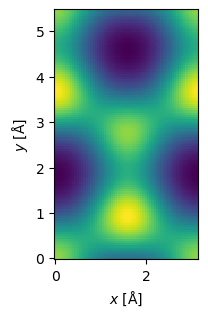

In [16]:
image_quasi_coherent.show(figsize=(4,3))

In [9]:
#im vollständig INKOHÄRENTEN Modell wird über Intensitäten bei verschiedenen Defoci integriert [genauer, siehe https://abtem.readthedocs.io/en/latest/user_guide/tutorials/partial_coherence.html]
#Integral = Intensitäten(f) * p(f), wo f=defocus, p= gewichtung in form von gaußverteilung, daher abTEM:

defocus_distribution = abtem.distributions.gaussian(#gaußverteilung aufsetzen
    center=ctf_coherent.defocus, #scherzer fokus als zentrum
    standard_deviation=focal_spread, #Fokusschwankung als standardabweichung
    num_samples=7,#7 bins aufsetzten (weils funktioniert)
    sampling_limit=1.5,)

ctf_incoherent = ctf_coherent.copy()
ctf_incoherent.defocus = defocus_distribution #defocus der ctf als Verteilung angeben

images_incoherent = exit_wave.apply_ctf(ctf_incoherent).intensity()
images_incoherent.compute()
images_incoherent.axes_metadata #informationen zu verschiedenen defoci gespeichert

[########################################] | 100% Completed | 111.41 ms


type           label    coordinates
-------------  -------  -----------------------
ParameterAxis  C10 [Å]  190.67 164.42 ... 33.17
RealSpaceAxis  x [Å]    0.00 0.05 ... 3.13
RealSpaceAxis  y [Å]    0.00 0.05 ... 5.46

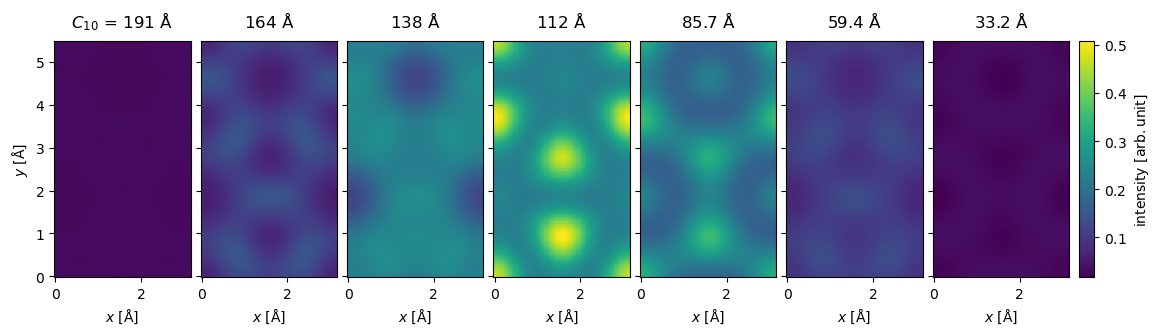

In [11]:
images_incoherent.show(explode=True, figsize=(13, 5),common_color_scale=True, cbar=True,)

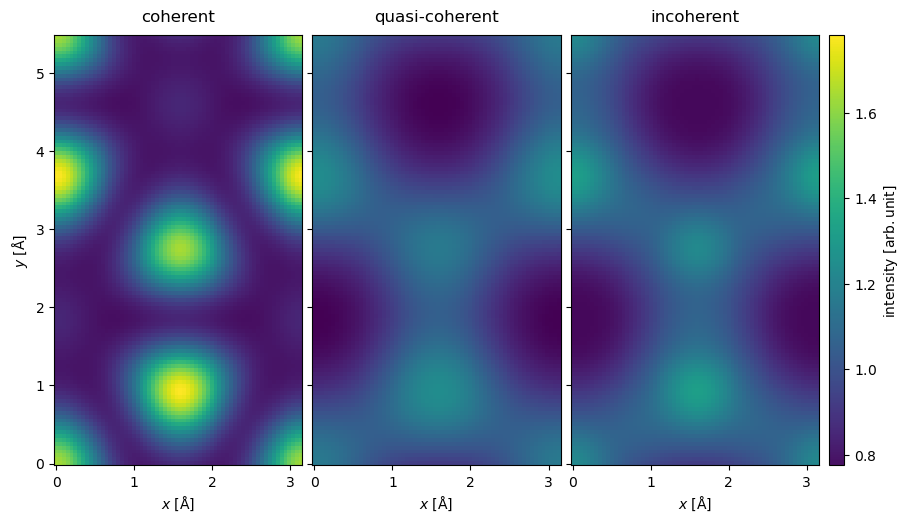

In [19]:
#create final inkoherent image and compare..
image_incoherent = images_incoherent.sum(0)

stack = abtem.stack([image_coherent, image_quasi_coherent, image_incoherent], ("coherent", "quasi-coherent", "incoherent"),)

stack.show(common_color_scale=True, explode=True, cbar=True, figsize=(18, 5),);

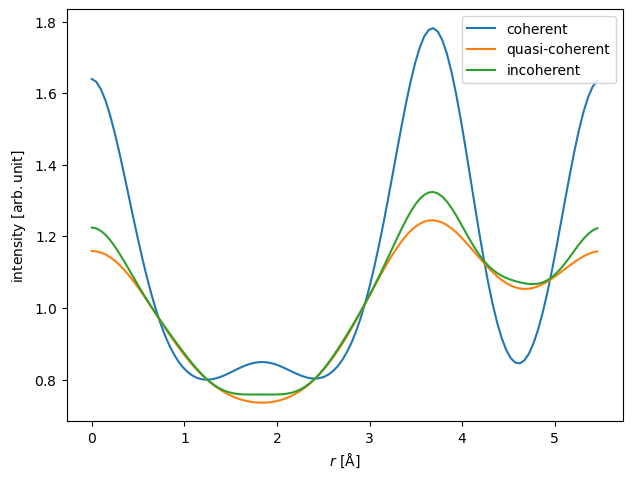

In [20]:
#vgl linienprofile
stack.interpolate_line(start=(0, 0), end=(0, stack.extent[1])).show(legend=True);
#It should be noted that the quasi-coherent model is better for smaller focal spread, hence, it may be more appropriate at higher electron energies.

### fun with probes

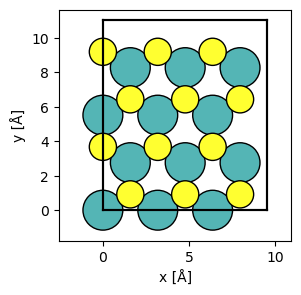

In [24]:
#[...] now we need multislice operator -> for every focal spread - \Delta f - sample, the multislice algorithm is needet -> expensive
# for spacial coherence -> almost free because already covered by other steps (equivalent to applying gaussian filter)[...]

#test system
atoms = ase.build.mx2(vacuum=2)
atoms = abtem.orthogonalize_cell(atoms) * (3, 2, 1)
abtem.show_atoms(atoms, figsize=(3,3));

#probe
energy = 80e3
probe_coherent = abtem.Probe(energy=energy, semiangle_cutoff=30, sampling=0.05)

In [25]:
#We define a Gaussian distribution over the defocus. -> vgl. anleitung für 18,75 anstrom
chromatic_aberration = 1.0 * 1e-3 * 1e10
energy_spread = 0.15
focal_spread = chromatic_aberration * energy_spread / energy

defocus_distribution = abtem.distributions.gaussian(
    center=0.0,
    standard_deviation=focal_spread,
    num_samples=11,
    sampling_limit=2,
    ensemble_mean=False,
)

print("Focal spread =", focal_spread, "Å")

Focal spread = 18.75 Å


In [27]:
#multisclicing
probe_temporal = abtem.Probe(energy=energy, semiangle_cutoff=30, sampling=0.05, defocus=defocus_distribution)
detector = abtem.PixelatedDetector()

scan = abtem.GridScan((0, 0), (1 / 3, 1 / 2), fractional=True, potential=atoms)
measurement_coherent = probe_coherent.scan(atoms, detectors=detector, scan=scan).compute()

measurement_temporal = probe_temporal.scan(atoms, detectors=detector, scan=scan).compute()

[########################################] | 100% Completed | 10.78 ss
[########################################] | 100% Completed | 48.09 s


In [29]:
source_size = 0.3

measurement_spatial = measurement_coherent.gaussian_source_size(source_size)
measurement_temporal_spatial = measurement_temporal.gaussian_source_size(source_size)

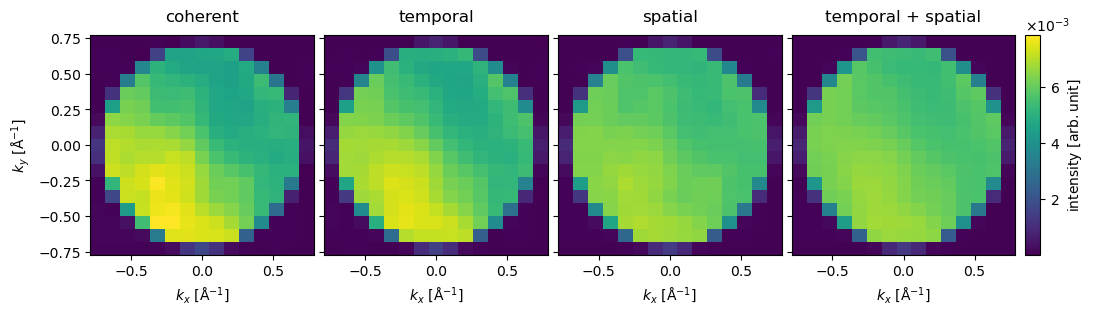

In [31]:
stacked = abtem.stack(
    (
        measurement_coherent,
        measurement_temporal,
        measurement_spatial,
        measurement_temporal_spatial,
    ),
    ("coherent", "temporal", "spatial", "temporal + spatial"),
)

stacked[:, 1, 1].crop(30).show(
    figsize=(12, 6),
    explode=True,
    common_color_scale=True,
    cbar=True,
);
#It is immediately clear that partial coherence reduces the contrast in the diffraction patterns.

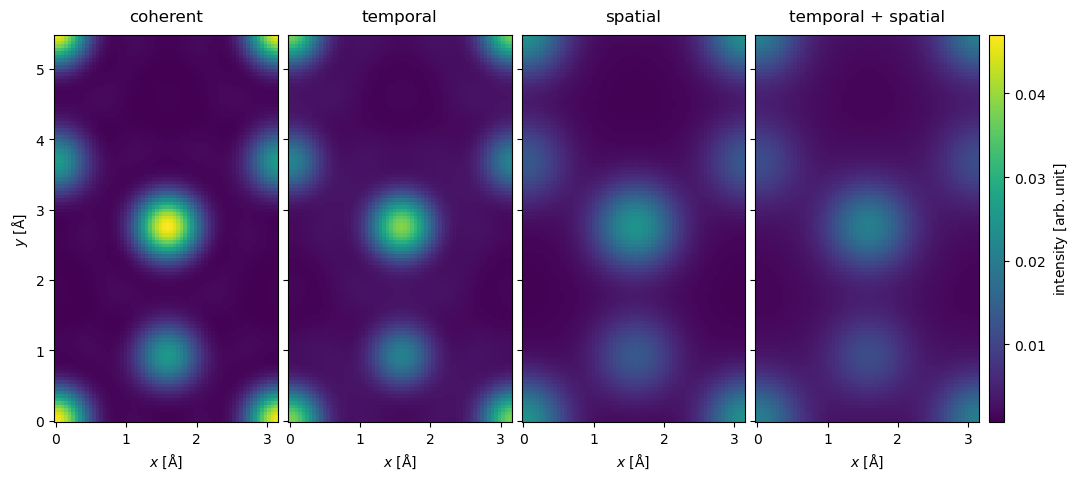

In [32]:
#medium angle scattering intensity
stacked.integrate_radial(50, 150).interpolate(0.05).show(
    figsize=(12, 6),
    explode=True,
    common_color_scale=True,
    cbar=True,);

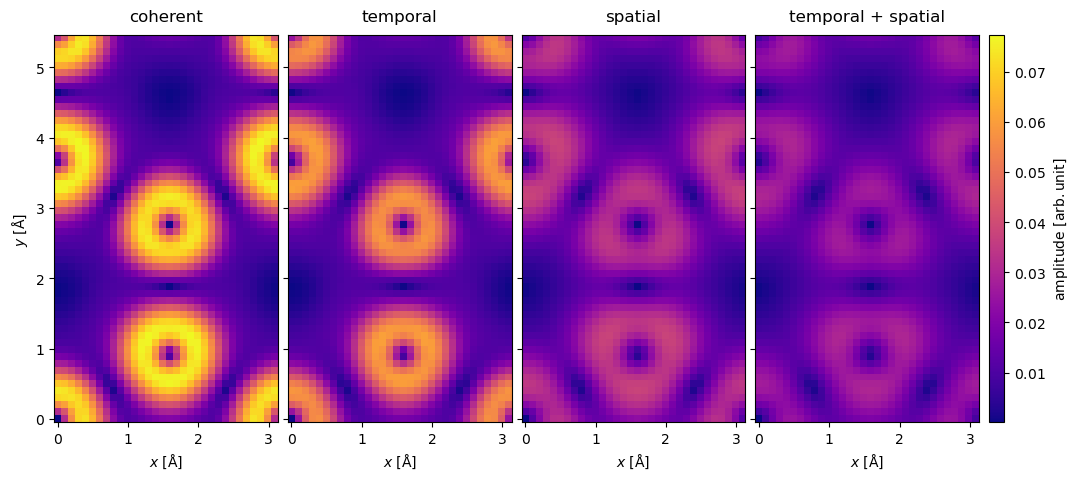

In [33]:
#ceter of mass
stacked.center_of_mass().interpolate(0.1).abs().show(
    figsize=(12, 6),
    explode=True,
    common_color_scale=True,
    cbar=True,
    cmap="plasma",
);


The preceding results show that partial spatial coherence is very important, we see that it both lowers the contrast and generally changes both the integrated and COM images. Partial temporal coherence, even at this low energy, had a less important role and its main main contribution was to lower the contrast. We should also note that the cost of including partial spatial coherence is almost non-existent, whereas partial temporal coherence may give a ~10x overhead.

